In [1]:
#importing packages
import numpy as np
import pandas as pd
import yfinance as yf
import statsmodels.api as sm
import scipy.optimize as spop
import matplotlib.pyplot as plt

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


stop-loss triggered
stop-loss triggered
stop-loss triggered
stop-loss triggered
stop-loss triggered
stop-loss triggered
stop-loss triggered
stop-loss triggered
stop-loss triggered
stop-loss triggered
stop-loss triggered
Long Signal:  CHI
Short Signal:  EBAY


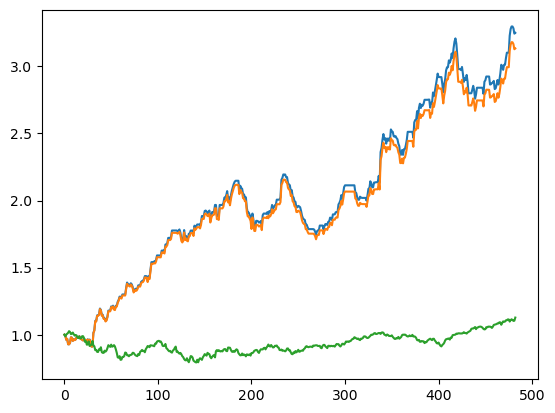

In [2]:
#specifying rolling window length
window = 21
#specifying maximum KPSS statistic (95% critical value)
KPSS_max = 0.463
#specifying the KPSS test (one-parameter unbiased or two-parameter)
unbiased = 1
#specifying whether to perform beta-loading or not
beta_loading = 0
#strategy parameters - trading fee, optimal entry (divergence), and stop-loss
fee = 0.0001
entry = 0.02
stop_loss = -0.05
#initially start in cash
signal = 1
current_return = 0
position0 = 0
position1 = 0
#specifying the sample
start = '2022-02-18'
end = '2024-02-23'
#specifying the pair <- THIS IS OUR VALUE ADDED
tickers = ['CHI', 'EBAY']
#specifying the market index
market = '^GSPC'
#initialising arrays
gross_returns = np.array([])
net_returns = np.array([])
market_returns = np.array([])
signals = np.array([])
KPSS_stats = np.array([])
raw_data = pd.DataFrame()
#downloading price data for stocks and the market index
for ticker in tickers:
    raw_data[ticker] = yf.download(ticker, start, end)['Close']
raw_data['market'] = yf.download(market, start, end)['Close']
#moving in a loop through the sample
for t in range(window, len(raw_data)-1):
    old_signal = signal
    old_position0 = position0
    old_position1 = position1
    #specifying the subsample
    data = raw_data[t-window:t]
    #stock 2 = a + b*stock 1
    #OLS parameters as starting values
    reg = sm.OLS(np.array(data[tickers[1]]), sm.add_constant(np.array(data[tickers[0]])))
    res = reg.fit()
    a0 = res.params[0]
    b0 = res.params[1]
    if unbiased == 1:
        #defining the KPSS function (unbiased one-parameter forecast)
        def KPSS(b):
            a = np.average(data[tickers[1]] - b*data[tickers[0]])
            resid = np.array(data[tickers[1]] - (a + b*data[tickers[0]]))
            cum_resid = np.cumsum(resid)
            st_error = (np.sum(resid**2)/(len(resid)-2))**(1/2)
            KPSS = np.sum(cum_resid**2)/(len(resid)**2*st_error**2)
            return KPSS
        #minimising the KPSS function (maximising the stationarity)
        res = spop.minimize(KPSS, b0, method='Nelder-Mead')
        KPSS_opt = res.fun
        #retrieving optimal parameters
        b_opt = float(res.x)
        a_opt = np.average(data[tickers[1]] - b_opt*data[tickers[0]]) 
    else:
        #defining the KPSS function (two-parameter)
        def KPSS2(kpss_params):
            a = kpss_params[0]
            b = kpss_params[1]
            resid = np.array(data[tickers[1]] - (a + b*data[tickers[0]]))
            cum_resid = np.cumsum(resid)
            st_error = (np.sum(resid**2)/(len(resid)-2))**(1/2)
            KPSS = np.sum(cum_resid**2)/(len(resid)**2*st_error**2)
            return KPSS
        #minimising the KPSS function (maximising the stationarity)
        res = spop.minimize(KPSS2, [a0, b0], method='Nelder-Mead')
        #retrieving optimal parameters
        KPSS_opt = res.fun
        a_opt = res.x[0]
        b_opt = res.x[1]
    #simulate trading
    #first check whether stop-loss is violated
    if current_return < stop_loss:
        signal = 0
        print('stop-loss triggered')
    #if we are already in position, check whether the equilibrium is restored, continue in position if not
    elif np.sign(raw_data[tickers[1]][t] - (a_opt + b_opt*raw_data[tickers[0]][t])) == old_signal:
        signal = old_signal
    else:
        #only trade if the pair is cointegrated
        if KPSS_opt > KPSS_max:
            signal = 0
        #only trade if there are large enough profit opportunities (optimal entry)
        elif abs(raw_data[tickers[1]][t]/(a_opt + b_opt*raw_data[tickers[0]][t])-1) < entry:
            signal = 0
        else:
            signal = np.sign(raw_data[tickers[1]][t] - (a_opt + b_opt*raw_data[tickers[0]][t]))
    #calculate strategy returns with beta loading
    if beta_loading == 1:
        rets0 = np.array(raw_data[tickers[0]][t-window:t-1])/np.array(raw_data[tickers[0]][t-window+1:t]) - 1
        rets1 = np.array(raw_data[tickers[1]][t-window:t-1])/np.array(raw_data[tickers[1]][t-window+1:t]) - 1
        rets_mkt = np.array(raw_data['market'][t-window:t-1])/np.array(raw_data['market'][t-window+1:t]) - 1
        reg = sm.OLS(rets0, sm.add_constant(rets_mkt))
        res = reg.fit()
        beta0 = res.params[1]
        reg = sm.OLS(rets1, sm.add_constant(rets_mkt))
        res = reg.fit()
        beta1 = res.params[1]
        position0 = beta1*signal
        position1 = -beta0*signal
    #calculate strategy returns without beta loading
    else:
        position0 = signal
        position1 = -signal
    #calculating returns
    gross = position0*(raw_data[tickers[0]][t+1]/raw_data[tickers[0]][t] - 1) + position1*(raw_data[tickers[1]][t+1]/raw_data[tickers[1]][t] - 1)
    net = gross - fee*(abs(position0 - old_position0) + abs(position1 - old_position1))
    market = raw_data['market'][t+1]/raw_data['market'][t] - 1
    if signal == old_signal:
        current_return = (1+current_return)*(1+gross)-1
    else:
        current_return = gross
    #populating arrays
    KPSS_stats = np.append(KPSS_stats, KPSS_opt)
    signals = np.append(signals, signal)
    gross_returns = np.append(gross_returns, gross)
    net_returns = np.append(net_returns, net)
    market_returns = np.append(market_returns, market)
#building the output dataframe
output = pd.DataFrame()
output['KPSS'] = KPSS_stats
output['signal'] = signals
output['gross'] = gross_returns
output['net'] = net_returns
output['market'] = market_returns
#visualising the results
plt.plot(np.append(1,np.cumprod(1+gross_returns)))
plt.plot(np.append(1,np.cumprod(1+net_returns)))
plt.plot(np.append(1,np.cumprod(1+market_returns)))

# Output signal
long_signal = ''
short_signal = ''
if signal == 1:
    long_signal = tickers[0]
    short_signal = tickers[1]
elif signal == -1:
    long_signal = tickers[1]
    short_signal = tickers[0]

print("Long Signal: ", long_signal)
print("Short Signal: ", short_signal)

In [3]:
signal

1.0

In [4]:
for date, signal in zip(output.index, signals):
    print(date, signal)

0 1.0
1 1.0
2 1.0
3 1.0
4 0.0
5 1.0
6 1.0
7 -1.0
8 -1.0
9 -1.0
10 -1.0
11 -1.0
12 -1.0
13 0.0
14 0.0
15 -1.0
16 -1.0
17 -1.0
18 -1.0
19 -1.0
20 -1.0
21 -1.0
22 1.0
23 1.0
24 1.0
25 1.0
26 1.0
27 1.0
28 1.0
29 0.0
30 1.0
31 -1.0
32 -1.0
33 1.0
34 1.0
35 0.0
36 1.0
37 1.0
38 -1.0
39 -1.0
40 -1.0
41 -1.0
42 0.0
43 -1.0
44 -1.0
45 -1.0
46 -1.0
47 0.0
48 0.0
49 -1.0
50 -1.0
51 -1.0
52 -1.0
53 1.0
54 1.0
55 0.0
56 -1.0
57 -1.0
58 -1.0
59 1.0
60 1.0
61 1.0
62 0.0
63 0.0
64 0.0
65 1.0
66 1.0
67 -1.0
68 -1.0
69 -1.0
70 -1.0
71 -1.0
72 -1.0
73 -1.0
74 -1.0
75 -1.0
76 -1.0
77 -1.0
78 -1.0
79 0.0
80 0.0
81 1.0
82 1.0
83 1.0
84 1.0
85 1.0
86 0.0
87 -1.0
88 -1.0
89 -1.0
90 -1.0
91 -1.0
92 1.0
93 0.0
94 -1.0
95 -1.0
96 -1.0
97 -1.0
98 -1.0
99 0.0
100 0.0
101 1.0
102 1.0
103 1.0
104 0.0
105 -1.0
106 -1.0
107 -1.0
108 0.0
109 -1.0
110 -1.0
111 0.0
112 0.0
113 1.0
114 1.0
115 0.0
116 0.0
117 0.0
118 0.0
119 0.0
120 -1.0
121 -1.0
122 -1.0
123 -1.0
124 -1.0
125 -1.0
126 -1.0
127 -1.0
128 1.0
129 1.0
130 1

In [5]:
for date, signal, return_value, stoploss_value in zip(output.index, signal, current_return, stop_loss):
    print(date, "Signal:", signal, "Current Return:", return_value , "Stop Loss:", stoploss_value)

TypeError: 'numpy.float64' object is not iterable

In [ ]:
current_return


In [ ]:
stop_loss

In [ ]:
position1

In [ ]:
position0

# 